# TensorFlow Content-based Filtering with Embedding (Paragraph2vec)


http://cs.stanford.edu/~quocle/paragraph_vector.pdf

http://research.google.com/pubs/pub44894.html

https://www.tensorflow.org/tutorials/word2vec

## Movielens Dataset

[Notebook](MovieLens Small Dataset.ipynb)

### TensorFlow Paragraph2vec

In [1]:
import csv

items = dict() # dict of id -> text (words)
ignored = list()

with open('movielens/ml-latest-small/plots.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_plot in reader:
        if movie_plot == 'N/A':
            ignored.append(movie_id)
            continue
        items[movie_id] = movie_plot

print('Number of movies: {:,d}'.format(len(items)))
print('Number of N/A: {:,d}'.format(len(ignored)))

Number of movies: 9,106
Number of N/A: 19


In [2]:
from scipy import stats

sizes = list(len(movie_plot) for movie_plot in items.values())
stats.describe(sizes)

DescribeResult(nobs=9106, minmax=(17, 5585), mean=432.19646386997584, variance=124206.00763603917, skewness=2.2178175245869074, kurtosis=10.294480522289218)

In [3]:
names = dict() # dict of id -> name

with open('movielens/ml-latest-small/movies.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for movie_id, movie_name, _ in reader:
        names[movie_id] = movie_name

len(names)

9125

In [4]:
import nltk
import os

nltk_data_dir = os.path.abspath('./nltk_data')
nltk.download('punkt', download_dir=nltk_data_dir)
nltk.data.path.insert(0, nltk_data_dir)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/cavani/Workspace/tensorflow-
[nltk_data]     jupyter/workspace/Recommendation/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
for movie_id, movie_plot in list(items.items())[:5]:
    print(names.get(movie_id, movie_id))
    print()
    print(movie_plot)
    print()
    print(nltk.word_tokenize(movie_plot.lower()))
    print()

Jumanji (1995)

After being trapped in a jungle board game for 26 years, a Man-Child wins his release from the game. But, no sooner has he arrived that he is forced to play again, and this time sets the creatures of the jungle loose on the city. Now it is up to him to stop them.

['after', 'being', 'trapped', 'in', 'a', 'jungle', 'board', 'game', 'for', '26', 'years', ',', 'a', 'man-child', 'wins', 'his', 'release', 'from', 'the', 'game', '.', 'but', ',', 'no', 'sooner', 'has', 'he', 'arrived', 'that', 'he', 'is', 'forced', 'to', 'play', 'again', ',', 'and', 'this', 'time', 'sets', 'the', 'creatures', 'of', 'the', 'jungle', 'loose', 'on', 'the', 'city', '.', 'now', 'it', 'is', 'up', 'to', 'him', 'to', 'stop', 'them', '.']

Toy Story (1995)

A little boy named Andy loves to be in his room, playing with his toys, especially his doll named "Woody". But, what do the toys do when Andy is not with them, they come to life. Woody believes that he has life (as a toy) good. However, he must worr

In [6]:
import collections

VOCABULARY_SIZE = 50000

class DocumentCorpus:
    
    def __init__(self, documents, titles, document_ids, vocabulary_size=VOCABULARY_SIZE):
        self.documents = documents = dict((doc_id, documents[doc_id]) for doc_id in document_ids)
        self.titles = documents = dict((doc_id, titles[doc_id]) for doc_id in document_ids)
        
        documents_words = dict((doc_id, nltk.word_tokenize(doc_raw.lower()))
                               for doc_id, doc_raw in self.documents.items())
        
        words_flat = (word for doc_words in documents_words.values() for word in doc_words)
        words = collections.Counter(words_flat).most_common(vocabulary_size - 1)
        
        word_to_idx = dict((word, i+1) for i, (word, _) in enumerate(words))
        word_to_idx['UNK'] = 0
        word_from_idx = dict((idx, word) for word, idx in word_to_idx.items())
        
        self._word_to_idx = word_to_idx
        self._word_from_idx = word_from_idx
        
        document_vectors = list()
        document_to_idx = dict()
        document_from_idx = dict()
        
        unk_idx = word_to_idx['UNK']
        unk_count = 0
        
        for i, (doc_id, doc_words) in enumerate(documents_words.items()):
            doc_vec = list(word_to_idx.get(word, unk_idx) for word in doc_words)
            document_vectors.append(doc_vec)
            document_to_idx[doc_id] = i
            document_from_idx[i] = doc_id
            
            unk_count += doc_vec.count(unk_idx)
        
        words.insert(0, ('UNK', unk_count))
        
        self.document_vectors = document_vectors
        self.document_to_idx = document_to_idx
        self.document_from_idx = document_from_idx
        
        self.words = sorted(words, key=lambda w: w[1], reverse=True)
    
    @property
    def vocabulary_size(self):
        return len(self.words)
    
    @property
    def documents_size(self):
        return len(self.document_vectors)
    
    def most_common_words(self, n=5):
        return self.words[:n]
    
    def word_to_idx(self, word):
        return self._word_to_idx.get(word, 0) # 0 = UNK
    
    def word_from_idx(self, i):
        return self._word_from_idx[i]

    def raw_from_id(self, doc_id):
        return self.documents[doc_id]
    
    def raw_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.documents[doc_id]
    
    def title_from_id(self, doc_id):
        return self.titles[doc_id]
    
    def title_from_idx(self, i):
        doc_id = self.document_from_idx[i]
        return self.titles[doc_id]
    
    def vector_form_id(self, doc_id):
        i = self.document_to_idx[doc_id]
        return self.document_vectors[i]
    
    def vector_form_id_words(self, doc_id):
        doc_vec = self.vector_form_id(doc_id)
        return list(self.word_from_idx(w_i) for w_i in doc_vec)

train_ids = list(items.keys()) # list of id's
train_corpus = DocumentCorpus(items, names, train_ids)

print('Vocabulary size:\n')
print(train_corpus.vocabulary_size)
print('\nDocuments size:\n')
print(train_corpus.documents_size)
print('\nMost common words (+UNK):\n')
print(train_corpus.most_common_words())
print('\nDocument example: id={}\n'.format(train_ids[0]))
print(train_corpus.title_from_id(train_ids[0]), '\n')
print(train_corpus.raw_from_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id(train_ids[0]), '\n')
print(train_corpus.vector_form_id_words(train_ids[0]))

Vocabulary size:

38387

Documents size:

9106

Most common words (+UNK):

[(',', 39543), ('the', 37983), ('.', 29809), ('a', 24721), ('to', 22220)]

Document example: id=2

Jumanji (1995) 

After being trapped in a jungle board game for 26 years, a Man-Child wins his release from the game. But, no sooner has he arrived that he is forced to play again, and this time sets the creatures of the jungle loose on the city. Now it is up to him to stop them. 

[39, 78, 949, 8, 4, 1493, 1788, 339, 15, 9178, 77, 1, 4, 9179, 1494, 10, 1226, 27, 2, 339, 3, 24, 1, 129, 4979, 26, 11, 2287, 16, 11, 9, 319, 5, 351, 240, 1, 6, 43, 71, 355, 2, 1122, 7, 2, 1493, 1741, 18, 2, 123, 3, 96, 31, 9, 40, 5, 29, 5, 228, 51, 3] 

['after', 'being', 'trapped', 'in', 'a', 'jungle', 'board', 'game', 'for', '26', 'years', ',', 'a', 'man-child', 'wins', 'his', 'release', 'from', 'the', 'game', '.', 'but', ',', 'no', 'sooner', 'has', 'he', 'arrived', 'that', 'he', 'is', 'forced', 'to', 'play', 'again', ',', 'and', 'thi

In [7]:
import numpy as np

class DocumentBatchGenerator:
    
    def __init__(self, document_vectors, batch_size, num_skips, skip_window):
        assert batch_size % num_skips == 0
        assert num_skips <= 2 * skip_window

        self.num_epoch = 0
        self.document_vectors = document_vectors
        self.document_index = 0
        self.word_index = 0
        
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        
        self.window_size = 2 * skip_window + 1 # [ skip_window target skip_window ]

        self.window = collections.deque(maxlen=self.window_size)
        self.window_init()
        
    def window_init(self):
        for _ in range(self.window_size):
            self.window_next_word()
    
    def window_next_word(self):
        words = self.document_vectors[self.document_index]
        self.window.append(words[self.word_index % len(words)])
        self.word_index += 1
        
    def window_forward(self):
        words = self.document_vectors[self.document_index]
        if self.word_index >= len(words):
            next_document = self.document_index + 1
            if next_document == len(self.document_vectors):
                self.document_index = 0
                self.num_epoch += 1
            else:
                self.document_index = next_document
            self.word_index = 0
            self.window_init()
        else:
            self.window_next_word()
    
    def read(self):
        docs = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        batch = np.ndarray(shape=(self.batch_size), dtype=np.int32)
        labels = np.ndarray(shape=(self.batch_size, 1), dtype=np.int32)
        
        for i in range(self.batch_size // self.num_skips):
            center = self.skip_window
            target = center
            targets_to_avoid = [ center ]
            for j in range(self.num_skips):
                while target in targets_to_avoid:
                    target = np.random.randint(0, self.window_size)
                targets_to_avoid.append(target)
                docs[i * self.num_skips + j] = self.document_index
                batch[i * self.num_skips + j] = self.window[center]
                labels[i * self.num_skips + j, 0] = self.window[target]
            self.window_forward()

        return docs, batch, labels

data_reader = DocumentBatchGenerator(train_corpus.document_vectors, batch_size=10, num_skips=2, skip_window=1)

def print_batch():
    docs, batch, labels = data_reader.read()
    for i in range(len(batch)):
        print('{}: ({}, {}) -> ({}, {})'.format(docs[i],
                                          batch[i],
                                          train_corpus.word_from_idx(batch[i]),
                                          labels[i, 0],
                                          train_corpus.word_from_idx(labels[i, 0])))

print('1st Batch:\n')
print_batch()

print('\n2nd Batch:\n')
print_batch()

print('\n3rd Batch:\n')
print_batch()

1st Batch:

0: (78, being) -> (949, trapped)
0: (78, being) -> (39, after)
0: (949, trapped) -> (78, being)
0: (949, trapped) -> (8, in)
0: (8, in) -> (949, trapped)
0: (8, in) -> (4, a)
0: (4, a) -> (8, in)
0: (4, a) -> (1493, jungle)
0: (1493, jungle) -> (4, a)
0: (1493, jungle) -> (1788, board)

2nd Batch:

0: (1788, board) -> (339, game)
0: (1788, board) -> (1493, jungle)
0: (339, game) -> (1788, board)
0: (339, game) -> (15, for)
0: (15, for) -> (339, game)
0: (15, for) -> (9178, 26)
0: (9178, 26) -> (15, for)
0: (9178, 26) -> (77, years)
0: (77, years) -> (9178, 26)
0: (77, years) -> (1, ,)

3rd Batch:

0: (1, ,) -> (4, a)
0: (1, ,) -> (77, years)
0: (4, a) -> (9179, man-child)
0: (4, a) -> (1, ,)
0: (9179, man-child) -> (4, a)
0: (9179, man-child) -> (1494, wins)
0: (1494, wins) -> (9179, man-child)
0: (1494, wins) -> (10, his)
0: (10, his) -> (1226, release)
0: (10, his) -> (1494, wins)


In [8]:
import tensorflow as tf

tf.__version__

'1.2.0'

In [9]:
import os
import shutil

class Paragraph2vecModel:
    
    #documents_size
    #vocabulary_size
    #embedding_size
    #num_sampled
    #learning_rate
    
    #input_docs
    #input_data
    #input_labels
    #loss
    #train
    #docs_embeddings
    #words_embeddings
    
    def __init__(self,
                 documents_size,
                 vocabulary_size,
                 embedding_size,
                 num_sampled,
                 learning_rate):
        self.documents_size = documents_size
        self.vocabulary_size = vocabulary_size
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        
        self.build_graph()
    
    def build_graph(self):
        self.input_docs = tf.placeholder(tf.int32, shape=[None])
        self.input_data = tf.placeholder(tf.int32, shape=[None])
        self.input_labels = tf.placeholder(tf.int32, shape=[None, 1])
        
        init_width = 0.5 / self.embedding_size
        
        docs_embeddings = tf.Variable(
            tf.random_uniform(
                [self.documents_size, self.embedding_size],
                -init_width,
                init_width),
            name='docs_embeddings')
        docs_lookup = tf.nn.embedding_lookup(docs_embeddings, self.input_docs)

        words_embeddings = tf.Variable(
            tf.random_uniform(
                [self.vocabulary_size, self.embedding_size],
                -init_width,
                init_width),
            name='words_embeddings')
        words_lookup = tf.nn.embedding_lookup(words_embeddings, self.input_data)

        embed = tf.concat([docs_lookup, words_lookup], 1)
        
        nce_weights = tf.Variable(
            tf.truncated_normal(
                [self.vocabulary_size, 2 * self.embedding_size],
                stddev=1.0 / np.sqrt(2 * self.embedding_size)))
        nce_biases = tf.Variable(tf.zeros([self.vocabulary_size]))
    
        self.loss = tf.reduce_mean(
            tf.nn.nce_loss(
                weights=nce_weights,
                biases=nce_biases,
                labels=self.input_labels,
                inputs=embed,
                num_sampled=self.num_sampled,
                num_classes=self.vocabulary_size))

        self._lr = tf.Variable(self.learning_rate, trainable=False)
        self._new_lr = tf.placeholder(tf.float32, shape=[], name="new_learning_rate")
        self._lr_update = tf.assign(self._lr, self._new_lr)
        
        global_step = tf.Variable(0, name='global_step', trainable=False)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=self._lr)
        #self.train = optimizer.minimize(self.loss, global_step=global_step, gate_gradients=optimizer.GATE_NONE)
        self.train = optimizer.minimize(self.loss, global_step=global_step)

        docs_norm = tf.sqrt(tf.reduce_sum(tf.square(docs_embeddings), 1, keep_dims=True))
        self.docs_embeddings = docs_embeddings / docs_norm
        
        words_norm = tf.sqrt(tf.reduce_sum(tf.square(words_embeddings), 1, keep_dims=True))
        self.words_embeddings = words_embeddings / words_norm

    def lr(self, session):
        return session.run(self._lr)
    
    def assign_lr(self, session, lr_value):
        session.run(self._lr_update, feed_dict={self._new_lr: lr_value})


class NearestWordsQuery:
    
    def __init__(self, embeddings, mapping, words, k=8):
        input_words = tf.constant(words, dtype=tf.int32)
        words_embeddings = tf.nn.embedding_lookup(embeddings, input_words)
        similarity = tf.matmul(words_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.words = words

    def word_from_idx(self, i):
        return self.mapping.word_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, word_idx in enumerate(self.words):
            word = self.word_from_idx(word_idx)
            nearest_pairs = zip(nearest_idx[i], nearest_val[i])
            next(nearest_pairs)
            nearest_words = ', '.join('{} ({:,.3f})'.format(self.word_from_idx(w_i), w_n)
                                      for w_i, w_n in nearest_pairs)
            print('Nearest to {}: {}'.format(word, nearest_words))


class NearestDocsQuery:
    
    def __init__(self, embeddings, mapping, docs, k=3):
        input_docs = tf.constant(docs, dtype=tf.int32)
        docs_embeddings = tf.nn.embedding_lookup(embeddings, input_docs)
        similarity = tf.matmul(docs_embeddings, embeddings, transpose_b=True)
        self.nearest = tf.nn.top_k(similarity, k+1)
        
        self.mapping = mapping
        self.docs = docs

    def doc_from_idx(self, i):
        return self.mapping.title_from_idx(i), self.mapping.raw_from_idx(i)
    
    def run(self, session):
        nearest_val, nearest_idx = session.run(self.nearest)
        for i, doc_idx in enumerate(self.docs):
            doc_title, doc_text = self.doc_from_idx(doc_idx)
            print('{}\n\n{}\n'.format(doc_title, doc_text))
            for n, (near_idx, near_sim) in enumerate(zip(nearest_idx[i], nearest_val[i])):
                if n == 0:
                    continue
                near_title, near_text = self.doc_from_idx(near_idx)
                print('[ {}, {:,.3f} ] {}\n\n{}\n'.format(n, near_sim, near_title, near_text))
            print('---\n')


class Paragraph2vecTrainer:
    
    #corpus
    #batch_size
    #num_skips
    #skip_window
    #embedding_size
    #num_sampled

    def __init__(self,
                 corpus,
                 batch_size,
                 num_skips,
                 skip_window,
                 embedding_size,
                 num_sampled,
                 learning_rate,
                 logdir='log/paragraph2vec'):
        self.corpus = corpus
        self.batch_size = batch_size
        self.num_skips = num_skips
        self.skip_window = skip_window
        self.embedding_size = embedding_size
        self.num_sampled = num_sampled
        self.learning_rate = learning_rate
        self.logdir = logdir
    
    def remove_log(self):
        if os.path.isdir(self.logdir):
            shutil.rmtree(self.logdir)
    
    def train(self, num_epochs=1, delay_lr_decay=0, reset_log=True):
        if reset_log:
            self.remove_log()
        
        data_reader = self.data_reader()
        
        with tf.Graph().as_default():
            model = self.build_model()
            
            doc_query = self.nearest_docs(model)
            word_query = self.nearest_words(model)
            
            sv = tf.train.Supervisor(logdir=self.logdir)
            with sv.managed_session() as session:
                train_ops = [model.train, model.loss]
                average_loss = 0
            
                step = 0
                last_epoch = data_reader.num_epoch
                while data_reader.num_epoch < num_epochs:
                    batch_docs, batch_data, batch_labels = data_reader.read()
                    feed_dict = {
                        model.input_docs: batch_docs,
                        model.input_data: batch_data,
                        model.input_labels: batch_labels,
                    }
                
                    _, loss_val = session.run(train_ops, feed_dict=feed_dict)
                    average_loss += loss_val

                    if step % 5000 == 0:
                        if step > 0:
                            average_loss /= 5000
                        print('Average loss at step {:,d}: {:,.3f}'.format(step, average_loss))
                        average_loss = 0
                                
                    step += 1
                
                    if data_reader.num_epoch != last_epoch:
                        last_epoch = data_reader.num_epoch

                        lr = model.lr(session)
                        if last_epoch >= delay_lr_decay:
                            model.assign_lr(session, max(0.001, lr / 2))
                    
                        print()
                        print('Epoch {} (lr={:,.5f})'.format(last_epoch, lr))
                        print()
                        doc_query.run(session)
                        word_query.run(session)
                        print()

                print('Total steps: {:,d}'.format(step))
            
                docs_embeddings = session.run(model.docs_embeddings)
        
        return docs_embeddings
    
    def data_reader(self):
        return DocumentBatchGenerator(self.corpus.document_vectors,
                                      self.batch_size,
                                      self.num_skips,
                                      self.skip_window)

    def build_model(self):
        return Paragraph2vecModel(self.corpus.documents_size,
                                  self.corpus.vocabulary_size,
                                  self.embedding_size,
                                  self.num_sampled,
                                  self.learning_rate)
    
    def nearest_words(self, model):
        words = self.sample_words()
        return NearestWordsQuery(model.words_embeddings, self.corpus, words)
        
    def sample_words(self, sample_size=3):
        return np.random.choice(self.corpus.vocabulary_size - 1,
                                sample_size,
                                replace=False)

    def nearest_docs(self, model):
        docs = self.sample_docs()
        return NearestDocsQuery(model.docs_embeddings, self.corpus, docs)
        
    def sample_docs(self, sample_size=2):
        return np.random.choice(self.corpus.documents_size - 1,
                                sample_size,
                                replace=False)

In [10]:
%%time

trainer = Paragraph2vecTrainer(
    train_corpus,
    batch_size = 125,
    skip_window = 5,       # How many words to consider left and right.
    num_skips = 5,         # How many times to reuse an input to generate a label.
    embedding_size = 200,  # Dimension of the embedding vector.
    num_sampled = 25,      # Number of negative examples to sample.
    learning_rate = 0.5)   # Initial learning rate.

docs_embeddings = trainer.train(num_epochs=25, delay_lr_decay=10)
# docs_embeddings = trainer.train(num_epochs=1)

INFO:tensorflow:Starting standard services.
INFO:tensorflow:Saving checkpoint to path log/paragraph2vec/model.ckpt
INFO:tensorflow:Starting queue runners.
INFO:tensorflow:global_step/sec: 0
Average loss at step 0: 132.566
Average loss at step 5,000: 49.216
Average loss at step 10,000: 24.976
Average loss at step 15,000: 17.319
Average loss at step 20,000: 13.652
INFO:tensorflow:global_step/sec: 205.756
Average loss at step 25,000: 11.273

Epoch 1 (lr=0.50000)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.994 ] Hunger (2008)

Irish republican Bobby Sands leads the inmates of a Northern Irish prison in a hunger strike.

[ 2, 0.981 ] Blair Witch Project, The (1999)

Three film students vanish after traveling into a Maryland forest to film a documentary on the local Blair Witch legend, leaving only their footage behind.

[ 3, 0.980 ] Unsuspected, The (1947)

The secretary of an affably suave r

Average loss at step 110,000: 4.242
Average loss at step 115,000: 4.261
Average loss at step 120,000: 4.175
INFO:tensorflow:Saving checkpoint to path log/paragraph2vec/model.ckpt
INFO:tensorflow:global_step/sec: 205.157
Average loss at step 125,000: 4.157
Average loss at step 130,000: 4.131
Average loss at step 135,000: 4.105

Epoch 5 (lr=0.50000)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.992 ] Hunger (2008)

Irish republican Bobby Sands leads the inmates of a Northern Irish prison in a hunger strike.

[ 2, 0.988 ] Dirty Work (1998)

A loser finds success in the revenge-for-hire business.

[ 3, 0.987 ] 3000 Miles to Graceland (2001)

A gang of ex-cons rob a casino during Elvis convention week.

---

Restrepo (2010)

Sebastian Junger and Tim Hetherington's year dug in with the Second Platoon in one of Afghanistan's most strategically crucial valleys reveals extraordinary insight into th


Epoch 9 (lr=0.50000)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.971 ] Lake of Fire (2006)

A graphic documentary on both sides of the abortion debate.

[ 2, 0.971 ] Comandante (2003)

Documentary on the director's meeting with Castro.

[ 3, 0.971 ] Richard Pryor Live on the Sunset Strip (1982)

Richard Pryor performs his stand-up comedy act on the Sunset Strip.

---

Restrepo (2010)

Sebastian Junger and Tim Hetherington's year dug in with the Second Platoon in one of Afghanistan's most strategically crucial valleys reveals extraordinary insight into the surreal combination of back breaking labor, deadly firefights, and camaraderie as the soldiers painfully push back the Taliban.

[ 1, 0.860 ] Dolly Sisters, The (1945)

Two sisters from Hungary become famous entertainers in the early 1900s. Fictionalized biography with lots of songs.

[ 2, 0.858 ] Toronto Stories (2008)

Various lives 

Average loss at step 355,000: 3.154
Average loss at step 360,000: 3.148
Average loss at step 365,000: 3.151
INFO:tensorflow:Saving checkpoint to path log/paragraph2vec/model.ckpt
Average loss at step 370,000: 3.154
Average loss at step 375,000: 3.138
Average loss at step 380,000: 3.106

Epoch 14 (lr=0.03125)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.953 ] Richard Pryor Live on the Sunset Strip (1982)

Richard Pryor performs his stand-up comedy act on the Sunset Strip.

[ 2, 0.953 ] I Know That Voice (2013)

Several voice actors discuss their art and their careers.

[ 3, 0.953 ] Comandante (2003)

Documentary on the director's meeting with Castro.

---

Restrepo (2010)

Sebastian Junger and Tim Hetherington's year dug in with the Second Platoon in one of Afghanistan's most strategically crucial valleys reveals extraordinary insight into the surreal combination of back breaking labor, de

Average loss at step 490,000: 3.068
Average loss at step 495,000: 3.098
Average loss at step 500,000: 3.108
Average loss at step 505,000: 3.101
Average loss at step 510,000: 3.099
Average loss at step 515,000: 3.073

Epoch 19 (lr=0.00100)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.953 ] Richard Pryor Live on the Sunset Strip (1982)

Richard Pryor performs his stand-up comedy act on the Sunset Strip.

[ 2, 0.953 ] I Know That Voice (2013)

Several voice actors discuss their art and their careers.

[ 3, 0.953 ] Comandante (2003)

Documentary on the director's meeting with Castro.

---

Restrepo (2010)

Sebastian Junger and Tim Hetherington's year dug in with the Second Platoon in one of Afghanistan's most strategically crucial valleys reveals extraordinary insight into the surreal combination of back breaking labor, deadly firefights, and camaraderie as the soldiers painfully push back th

Average loss at step 625,000: 3.068
Average loss at step 630,000: 3.091
Average loss at step 635,000: 3.104
Average loss at step 640,000: 3.097
Average loss at step 645,000: 3.098
Average loss at step 650,000: 3.065

Epoch 24 (lr=0.00100)

Shrek the Halls (2007)

This half-hour animated TV special features the Shrek characters putting their own spin on holiday traditions.

[ 1, 0.953 ] Richard Pryor Live on the Sunset Strip (1982)

Richard Pryor performs his stand-up comedy act on the Sunset Strip.

[ 2, 0.953 ] I Know That Voice (2013)

Several voice actors discuss their art and their careers.

[ 3, 0.953 ] Comandante (2003)

Documentary on the director's meeting with Castro.

---

Restrepo (2010)

Sebastian Junger and Tim Hetherington's year dug in with the Second Platoon in one of Afghanistan's most strategically crucial valleys reveals extraordinary insight into the surreal combination of back breaking labor, deadly firefights, and camaraderie as the soldiers painfully push back th

In [11]:
%%time

from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
low_dim_embs = tsne.fit_transform(docs_embeddings)
labels = list(train_corpus.document_from_idx[i] for i in range(docs_embeddings.shape[0]))

CPU times: user 2min 48s, sys: 16.4 s, total: 3min 5s
Wall time: 2min 56s


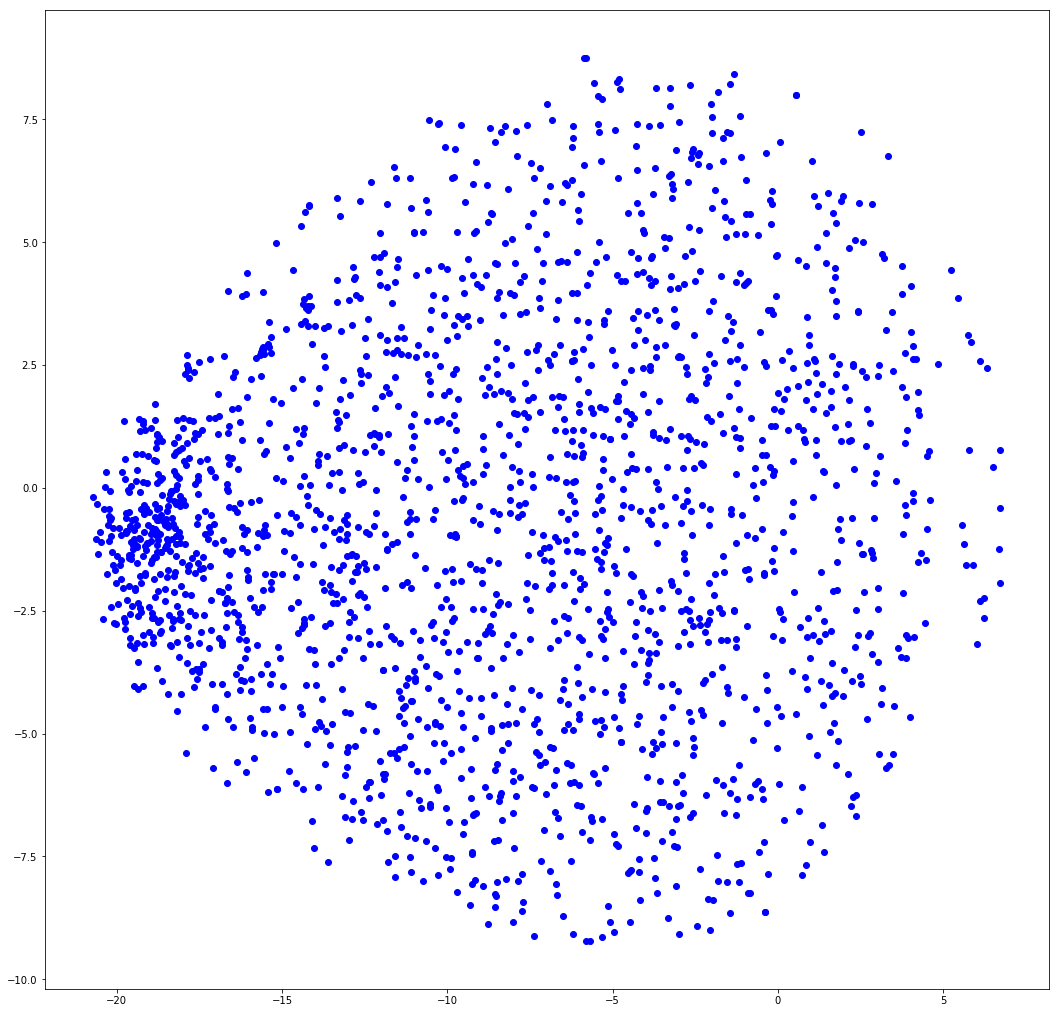

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt

points = np.random.choice(len(labels), 2000, replace=False)

plt.figure(figsize=(18, 18))  #in inches
for i in points:
    x, y = low_dim_embs[i,:]
    plt.scatter(x, y, color='b')
    #label = labels[i]
    #plt.annotate(
    #    label,
    #    xy=(x, y),
    #    xytext=(5, 2),
    #    textcoords='offset points',
    #    ha='right',
    #    va='bottom')

plt.show()

### Content-based User-Item: Avarage with Time Decay

In [13]:
import collections
import csv

MovieWatch = collections.namedtuple('MovieWatch', ['movie_id', 'timestamp'])

users = collections.defaultdict(list)
with open('movielens/ml-latest-small/ratings.csv', newline='') as f:
    reader = csv.reader(f)
    next(reader) # skip header
    for user_id, item_id, _, timestamp in reader:
        users[user_id].append(MovieWatch(item_id, int(timestamp)))

len(users)

671

In [14]:
from scipy import stats

watch_counts = list(len(movies) for movies in users.values())
stats.describe(watch_counts)

DescribeResult(nobs=671, minmax=(20, 2391), mean=149.03725782414307, variance=53465.901594857292, skewness=4.544628118876829, kurtosis=28.187338511028905)

In [15]:
user_items = dict()
for user, movies in users.items():
    items = list()
    movies = sorted(movies, key=lambda m: int(m.timestamp))
    for movie_id, _ in movies:
        if movie_id not in train_corpus.document_to_idx:
            continue
        i = train_corpus.document_to_idx[movie_id]
        items.append(i)
    user_items[user] = items

stats.describe(list(len(items) for items in user_items.values()))

DescribeResult(nobs=671, minmax=(20, 2390), mean=149.00745156482861, variance=53434.46113842116, skewness=4.543685375623357, kurtosis=28.17545840836149)

In [16]:
class Recommender:
    
    def __init__(self, item_embeddings, user_items, mapping, decay):
        self.item_embeddings = item_embeddings
        n_items = item_embeddings.shape[0]
        
        self.user_items = user_items
        self.user_u = dict()
        self.user_t = collections.defaultdict(int)
        self.user_h = collections.defaultdict(lambda: np.zeros(n_items))
        
        self.mapping = mapping
        self.decay = decay
    
    def user_vec(self, user_id, t):
        items = self.user_items[user_id]
        
        if t >= len(items):
            return self.user_u[user_id], self.user_h[user_id]
        
        i = items[t]
        v = self.item_embeddings[i]
        if t == 0:
            u = v
        else:
            u = v + self.decay * self.user_u[user_id]
            u = u / np.linalg.norm(u)
        self.user_u[user_id] = u
        h = self.user_h[user_id]
        h[i] = 1
        
        return u, h
        
    def recommend(self, user_id, k=3):
        if user_id not in self.user_items:
            return None
        
        t = self.user_t[user_id]
        self.user_t[user_id] += 1
        
        u, h = self.user_vec(user_id, t)
        
        d = np.dot(self.item_embeddings, u)
        d = np.multiply(d, 1 - h)
        rank = d.argsort()[::-1][:k]
        
        return list(self.mapping.document_from_idx[i] for i in rank)

In [17]:
user_id, items = list(user_items.items())[0]

print('{} (movies = {:,d})'.format(user_id, len(items)))
print()

rec = Recommender(docs_embeddings, user_items, train_corpus, 0.8)

for k, last_item in enumerate(items):
    print(train_corpus.title_from_idx(last_item))
    rec_items = rec.recommend(user_id)
    if k < len(items) - 10:
        continue
    print()
    for i, item_id in enumerate(rec_items):
        print('[ {} ] {}'.format(i+1, train_corpus.title_from_id(item_id)))
    print()

1 (movies = 20)

Antz (1998)
Fly, The (1986)
Blazing Saddles (1974)
Dracula (Bram Stoker's Dracula) (1992)
Cape Fear (1991)
Star Trek: The Motion Picture (1979)
Tron (1982)
Dangerous Minds (1995)
Gandhi (1982)
Deer Hunter, The (1978)
Dumbo (1941)

[ 1 ] Lifeforce (1985)
[ 2 ] Battle Hymn (1957)
[ 3 ] 3 Extremes (Three... Extremes) (Saam gaang yi) (2004)

Sleepers (1996)

[ 1 ] Desperado (1995)
[ 2 ] Mars Attacks! (1996)
[ 3 ] 52 Pick-Up (1986)

Escape from New York (1981)

[ 1 ] Mrs. Miniver (1942)
[ 2 ] Brüno (Bruno) (2009)
[ 3 ] Jazz (2001)

Ben-Hur (1959)

[ 1 ] Pokémon: The First Movie (1998)
[ 2 ] Hunger (2008)
[ 3 ] Teenage Mutant Ninja Turtles III (1993)

French Connection, The (1971)

[ 1 ] World Trade Center (2006)
[ 2 ] Rashomon (Rashômon) (1950)
[ 3 ] Jason Goes to Hell: The Final Friday (1993)

Gods Must Be Crazy, The (1980)

[ 1 ] First Beautiful Thing, The (La prima cosa bella) (2010)
[ 2 ] Quiet Man, The (1952)
[ 3 ] Good Hair (2009)

Willow (1988)

[ 1 ] 3 Extremes (Thr